In [1]:
import sys
import os
# Add project directory to Python path
sys.path.append(r'F:\FYP_DATA\ml_project')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Load data
data_path = '../data/processed/process.csv'
if not os.path.exists(data_path):
    print(f'Relative path {data_path} not found, using absolute path')
    data_path = r'F:\FYP_DATA\ml_project\data\processed\process.csv'
    if not os.path.exists(data_path):
        raise FileNotFoundError(f'Data file not found at {data_path}')
df = pd.read_csv(data_path)
X = df.drop(columns=['Unnamed: 0', 'water_Discharge'], axis=1)
y = df['water_Discharge']



f:\FYP_DATA\ml_project\mynew312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 0.6881 - mae: 0.6302 - val_loss: 0.4166 - val_mae: 0.5676
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2347 - mae: 0.3806 - val_loss: 0.2922 - val_mae: 0.4731
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1683 - mae: 0.3250 - val_loss: 0.1827 - val_mae: 0.3657
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1271 - mae: 0.2832 - val_loss: 0.0873 - val_mae: 0.2451
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0996 - mae: 0.2481 - val_loss: 0.0712 - val_mae: 0.2275
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0808 - mae: 0.2254 - val_loss: 0.0618 - val_mae: 0.2180
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0690 - mae: 0.2081 - val_loss: 0.0447 - val_mae: 0.1780
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0595 - mae: 0.1927 - val_loss: 0.0490 - val_mae: 0.1983
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.05

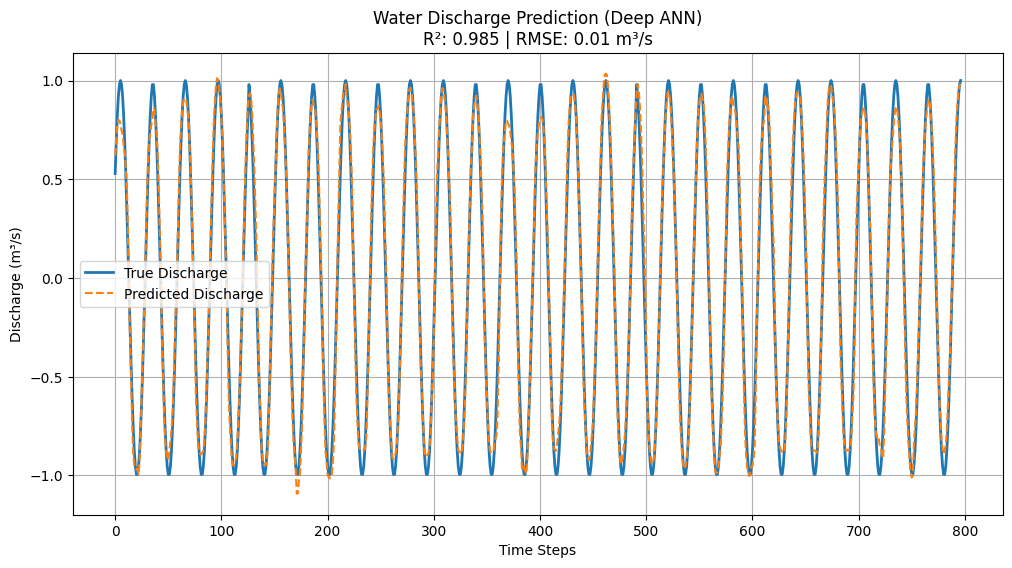

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load and preprocess data
data = df  # Columns: rainfall, max_temp, min_temp, avg_temp, water_discharge
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 2. Create sequences with windowing
window_size = 20  # Number of past days to consider
n_features = 4    # rainfall + 3 temperature features

X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size, :-1].flatten())  # Flatten 20 days of features
    y.append(scaled_data[i + window_size, -1])             # Corresponding discharge value

X = np.array(X)
y = np.array(y)

# 3. Train-test split (time-series aware)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Build deeper ANN model
model = Sequential([
    # Input layer (window_size * n_features = 20*4 = 80)
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    # Hidden layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),

    # Output layer
    Dense(1)
])

# 5. Compile and train
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=30, restore_best_weights=True)],
    verbose=1
)

# 6. Evaluate
y_pred = model.predict(X_test)

# Inverse scaling for discharge
dummy_matrix = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy_matrix[:, -1] = y_pred.flatten()
y_pred_orig = scaler.inverse_transform(dummy_matrix)[:, -1]

# True values inverse scaling
dummy_test = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_test[:, -1] = y_test
y_test_orig = scaler.inverse_transform(dummy_test)[:, -1]

# Metrics
from sklearn.metrics import r2_score, mean_squared_error
print(f"R² Score: {r2_score(y_test_orig, y_pred_orig):.4f}")
print(f"RMSE: {(mean_squared_error(y_test_orig, y_pred_orig)):.2f} m³/s")

# 7. Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='True Discharge', linewidth=2)
plt.plot(y_pred_orig, label='Predicted Discharge', linestyle='--')
plt.title('Water Discharge Prediction (Deep ANN)\n'
          f'R²: {r2_score(y_test_orig, y_pred_orig):.3f} | '
          f'RMSE: {(mean_squared_error(y_test_orig, y_pred_orig)):.2f} m³/s')
plt.xlabel('Time Steps')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.grid(True)
plt.show()
